In [1]:
import shapely.geometry
import pyproj
import osmnx as ox
import geopandas as gpd
#from mpl_toolkits.basemap import Basemap  #installing basemap along with geopandas/osmnx created big issues in the env
import pandas as pd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import csv

from shapely.geometry import Polygon
from shapely.geometry import Point

ox.settings.use_cache=True
ox.settings.log_console=True

In [2]:
pyproj.datadir.set_data_dir('C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj')
pyproj.datadir.get_data_dir()

'C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj'

### Create a regular spaced grid for the are of interest

In [4]:
#solution from https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python

# Set up transformers 'epsg:32616' is for Costa Rica
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:32616')
to_original_transformer = pyproj.Transformer.from_crs('epsg:32616', 'epsg:4326')

# Create corners of rectangle to be transformed to a grid. Defined by limits of area with PA fields
                                                     
sw = shapely.geometry.Point((10.09,-85.07)) #south, west
ne = shapely.geometry.Point((11.04, -83.40)) #north, east

stepsize = 5000 # 5 km grid step size


In [5]:
# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform sw points to 32616
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for ne

In [6]:
# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(to_original_transformer.transform(x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

with open('latloncandid.csv', 'w') as of:
    of.write('lon;lat\n')
    for p in gridpoints:
        of.write('{:f};{:f}\n'.format(p.x, p.y))

In [7]:
#read the created file containing the lat lon points and transform to geodataframe
df = pd.read_csv("latloncandid.csv", delimiter=';', skiprows=0, low_memory=False)

geometry = [Point(xy) for xy in zip(df['lat'], df['lon'])]
gdf = GeoDataFrame(df, geometry=geometry)   

In [8]:
#import shp of Costa Rica
crShape = gpd.read_file(r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/raw/geoCR.geojson')

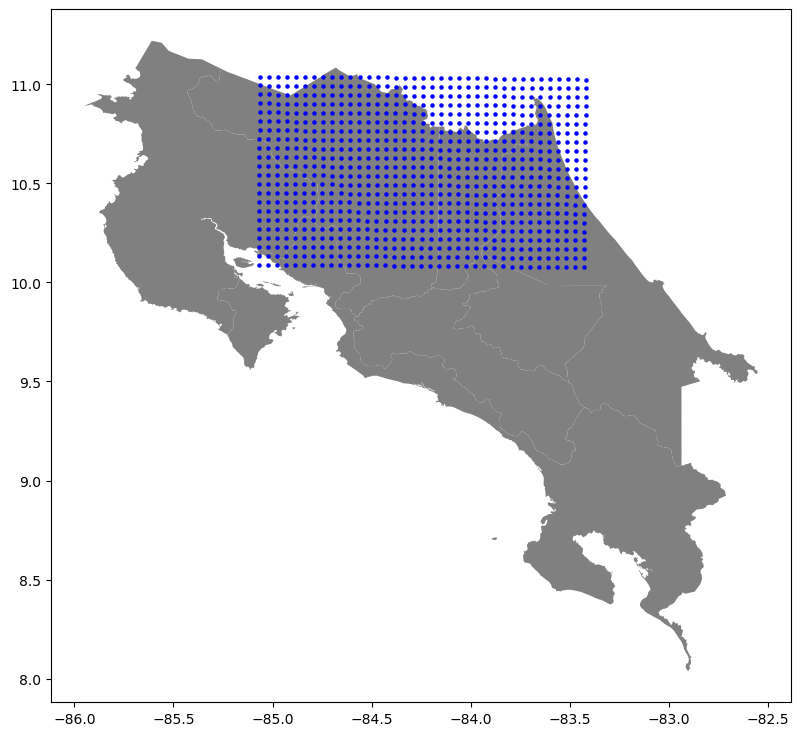

In [9]:
#Plot the generated grid
gdf.plot(ax=crShape.plot(figsize=(15, 9), color='grey'), marker='o', color='blue', markersize=5);

### We are not interested in the grid points outside the country

In [11]:
gdf = gdf.set_crs('epsg:4326')

In [12]:
candidates = gpd.sjoin(gdf, crShape, how='inner')

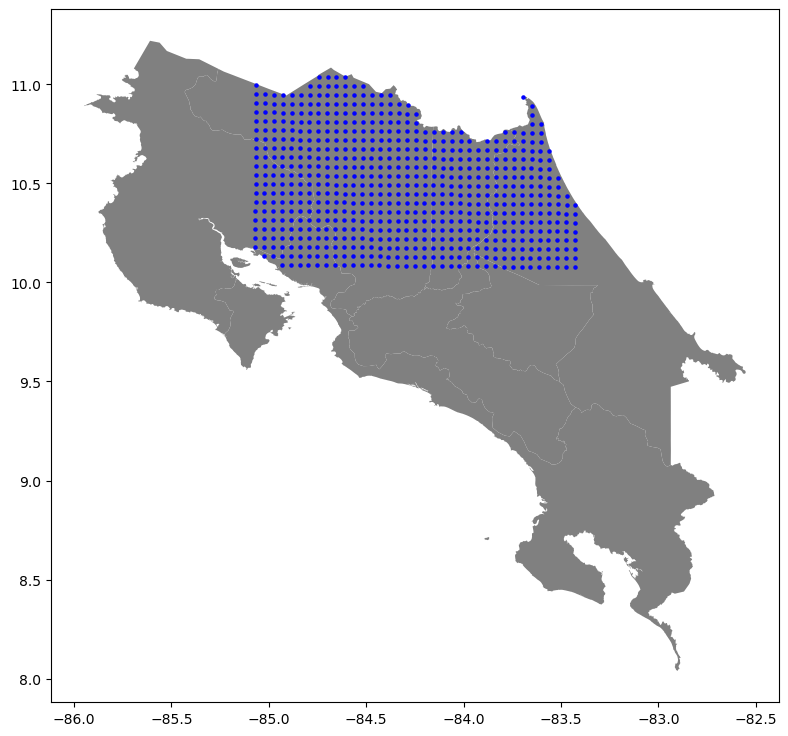

In [13]:
#Plot created grid
candidates.plot(ax=crShape.plot(figsize=(15, 9), color='grey'), marker='o', color='blue', markersize=5);

In [3]:
#candidates.to_file(r"C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/candidates.geojson", driver='GeoJSON')
candidates = gpd.read_file(r"C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/candidates.geojson")

In [5]:
## path to PA fields and network
networkFile = r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/cr_allPrivate.gpkg'

In [6]:
#load road network
gdf_nodes = gpd.read_file(networkFile, layer='nodes').set_index('osmid')
gdf_edges = gpd.read_file(networkFile, layer='edges').set_index(['u', 'v', 'key'])
assert gdf_nodes.index.is_unique and gdf_edges.index.is_unique

In [7]:
# convert the node/edge GeoDataFrames to a MultiDiGraph
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs)

In [8]:
G_proj = ox.project_graph(G)

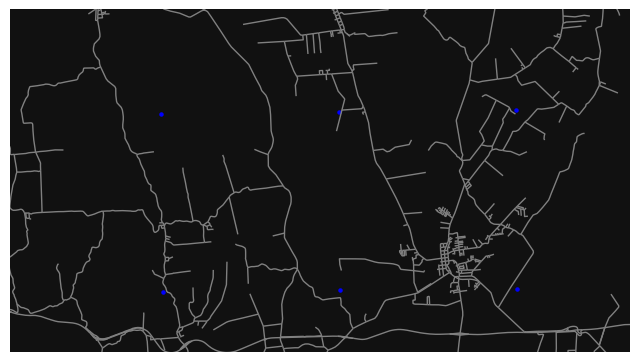

In [9]:
fig, ax = ox.plot_graph(G, edge_color='grey', edge_linewidth=1, node_size=0, show=False, bbox=(10.5167,10.4299,-84.3208,-84.1611))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='b', s=5, zorder=-1)

In [10]:
# project graph and points to same CRS
geom = gpd.points_from_xy(candidates['geometry'].x, candidates['geometry'].y)
gdf = gpd.GeoDataFrame(candidates, crs='epsg:4326').to_crs(G_proj.graph['crs'])

In [11]:
%%time
# calculate nearest edge to each point
neCan = ox.nearest_nodes(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y,  return_dist=True)

CPU times: total: 2.48 s
Wall time: 2.55 s


In [12]:
unique_edges=neCan[0]

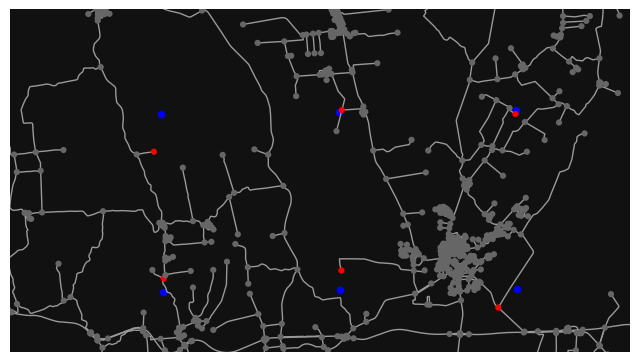

In [13]:
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
fig, ax = ox.plot_graph(G, node_color=ec, edge_linewidth=1, node_size=20, show=False, bbox=(10.5167,10.4299,-84.3208,-84.1611))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='blue', s=20, zorder=-1)

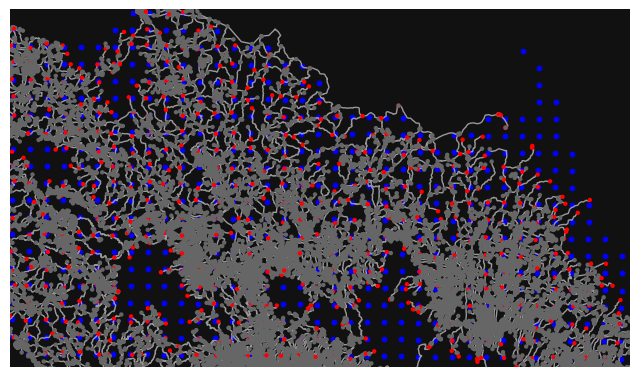

In [157]:
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
fig, ax = ox.plot_graph(G, node_color=ec,node_size=10, show=False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='blue', s=10, zorder=-5)

In [17]:
with open(r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/candiRegGrid.csv', 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    writer.writerow(neCan[0])

Note how there are no red dots in some areas, these are national parks without road networks. 

### We can also sample random points in the network

As per the OSMnx documentation: 
Unlike typical spatially uniform random sampling, this method accounts for the graph’s geometry. And unlike equal-length edge segmenting, this method guarantees uniform randomness.

In [3]:
northG = ox.graph.graph_from_bbox(11.2, 10.00, -83, -85.2, network_type = 'drive_service')

In [4]:
G_proj = ox.project_graph(northG)

In [5]:
Gs = ox.utils_graph.get_largest_component(northG, strongly=True)

In [6]:
len(northG.edges)

108805

In [7]:
len(Gs.edges)

108674

In [14]:
#save strongly connected network to folder
ox.save_graph_geopackage(Gs, filepath=r"C:\Users\isaldiviagonzatti\Downloads\gitFiles\MScThesisCode\FLP\output\strongNetwork.gpkg")

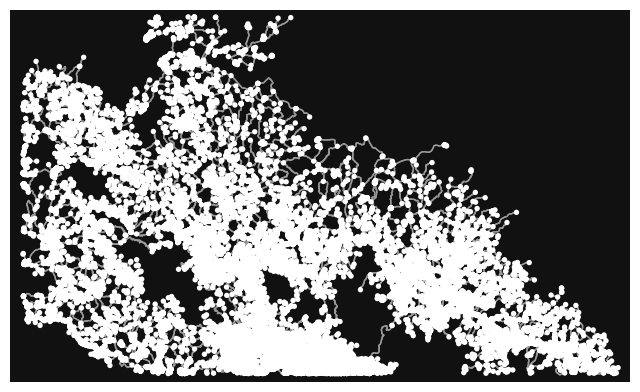

In [15]:
fig, ax = ox.plot_graph(Gs)

In [8]:
%%time
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(Gs), n=500)
X = points.x.values
Y = points.y.values

CPU times: total: 52 s
Wall time: 52.9 s


c:\Users\isaldiviagonzatti\anaconda3\envs\geoenv\lib\site-packages\osmnx\utils_geo.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return lines.interpolate(np.random.rand(n), normalized=True)


In [9]:
gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(points))
gdf["id"] = gdf.index

In [10]:
# project graph and points to same CRS
gdf = gpd.GeoDataFrame(gdf, crs='epsg:4326').to_crs(G_proj.graph['crs'])

In [11]:
%%time
# calculate nearest node to each point
neCan1 = ox.nearest_nodes(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y, return_dist=True)

CPU times: total: 1.25 s
Wall time: 1.33 s


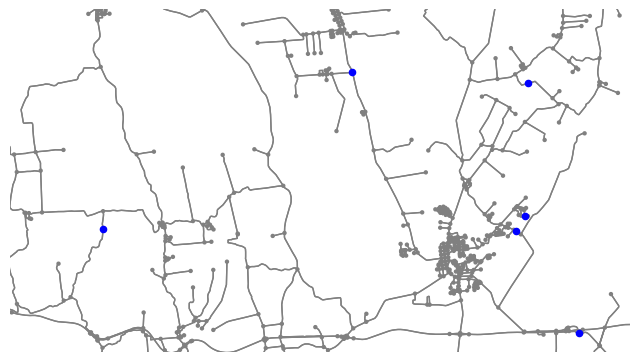

In [12]:
fig, ax = ox.plot_graph(northG, node_color= 'grey', bgcolor='white',  edge_color='grey', edge_linewidth=1, node_size=10, show=False, close=False, bbox=(10.5167,10.4299,-84.3208,-84.1611))
points.plot(ax=ax, markersize = 20, c='blue', zorder=1)
plt.show()

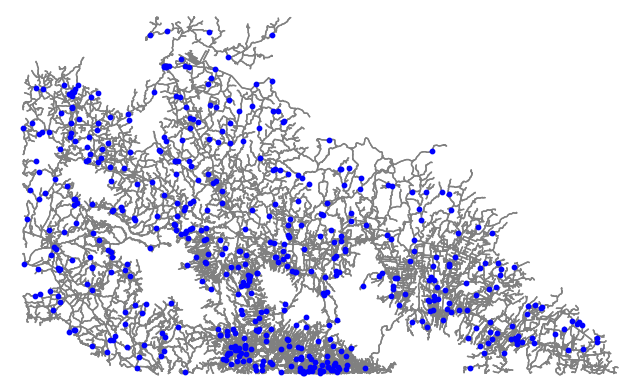

In [18]:
fig, ax = ox.plot_graph(northG, node_color='grey', bgcolor='white',  edge_color='grey', edge_linewidth=1, node_size=1, show=False, close=False)
points.plot(ax=ax, c='blue', zorder=1, markersize = 10)
plt.savefig('candidatesNet.pdf', bbox_inches='tight')

In [29]:
#save new candidates
with open(r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/canNetwork.csv', 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in neCan1:
        writer.writerow(tup)

In [147]:
# A longer way, with a different result, is to get the network from the centroid of all the PAL fields

# L = [
#      (10.09,-83.40),
#      (10.09,-83.40),
#      ( 11.04,-85.07),
#      ( 11.04,-85.07),
#     ]

# lat = []
# long = []
# for l in L :
#   lat.append(l[0])
#   long.append(l[1])

# latC = sum(lat)/len(lat)
# lonC = sum(long)/len(long)
# print(latC,lonC)

In [148]:
# constrain plot to a bounding box
# bbox = ox.utils_geo.bbox_from_point(point=(latC,lonC), dist=65000)
# fig, ax = ox.plot_graph(G, figsize=(5, 5), bbox=bbox)

In [ ]:
# plot with basemap, read note in packages importing 

# fig = plt.gcf()
# fig.set_size_inches(8, 6.5)

# m = Basemap(projection='lcc', lat_0 = 9., lon_0 = -85,
#     resolution = 'i', area_thresh = 0.1,
#     llcrnrlon=-87, llcrnrlat=9,
#     urcrnrlon=-82, urcrnrlat=13)
 
# m.drawcoastlines()
# m.bluemarble()

# x,y = m(df['lat'],  df['lon'])
# m.scatter(x, y, marker='o', color='Red',s=5)
 
# plt.show()